In [1]:
%load_ext autoreload
%autoreload 2

import builtins  # Not needed unless saving for github
builtins.use_bokeh_screenshot = True  # Not needed unless saving for github

from kaggle_speech_recog import *

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# First layer

## Get feature matrix

In [2]:
X_vector_len = 16000
test = SpeechList.get_test('test/audio')
X_test = test.get_spectrogram_feature_ndarray(vector_len=X_vector_len, spec_v='3', take_log=False)

/usr/local/anaconda3/lib/python3.5/site-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


## Get logits

In [3]:
path2log = 'logs/Ensemble_graph_04_9models_run_01.log'

In [4]:
log = pickle.load(open(path2log, 'rb'))

if hasattr(log.t_cnfg, 'ensemble_logs'):
    L_test = gather_logits(X_test, log_dir='logs', logs=log.t_cnfg.ensemble_logs)
    
GraphClass = globals()[log.graph_name]  # Pick up graph class used to train model
graph = GraphClass(log.g_cnfg)  # Load the same graph configuration

if hasattr(log.t_cnfg, 'ensemble_logs'):
    X2_test = graph.get_logits(L_test, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size, annotate=False)  # Use best model in checkpoint directory
else:
    X2_test = graph.get_logits(X_test, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size, annotate=False)

INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramMultiLSTMRandomInputModify_graph_03_lr_decay_run_01_group_unknown/best/model-57354
INFO:tensorflow:Restoring parameters from checkpoints/NoveltyDetectionSpectrogramMultiLSTMRandomInputModify_graph_01_run_01/best/model-82750
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramMultiLSTMRandomInputModify_graph_02_run_01/best/model-90650
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramMultiLSTMRandomInputModify2_graph_02_lower_lr_lr_decay_run_01_group_unknown/best/model-53088
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramCLSTMBidirectional_graph_03_run_01/best/model-17450
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramDSConvDropout_graph_01_run_01/best/model-22740
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramConcatCLSTM2_graph_01_run_01_group_unknown/best/model-23858
INFO:tensorflow:Restoring parameters from checkpoints/SpectrogramConcatCLS

# Second layer

## Add values from IsolationForest, OneClassSVM, XGBoost

In [5]:
# Load from saved
model_dict_iso_forest = pickle.load(open('_'.join(['IsolationForests', log.joined_name]), 'rb'))
model_dict_one_class_svm = pickle.load(open('_'.join(['OneClassSVMs', log.joined_name]), 'rb'))
xgboost = pickle.load(open('_'.join(['XGBoost', log.joined_name]), 'rb'))

In [6]:
list_X2 = [X2_test]

list_X2_iso_forest = get_values_with_sklearn_models(list_X2, model_dict_iso_forest)
list_X2_one_class_svm = get_values_with_sklearn_models(list_X2, model_dict_one_class_svm)
list_X2_xgboost = get_values_with_xgboost(list_X2, xgboost)

#list_L = [L_test]
to_concatenate = [list_X2, list_X2_iso_forest, list_X2_one_class_svm, list_X2_xgboost]
X2ext_test = get_concatenated(to_concatenate)[0]

## Predict

In [7]:
path2log = 'logs/Ensemble_graph_02_2nd_layer_for_Ensemble_graph_04_9models_run_01_run_01.log'

In [8]:
log = pickle.load(open(path2log, 'rb'))
GraphClass = globals()[log.graph_name]  # Pick up graph class used to train model
graph = GraphClass(log.g_cnfg)  # Load the same graph configuration
Y_test = graph.predict(X2ext_test, ckp_dir=log.ckp_dir, batch_size=log.t_cnfg.batch_size)  # Use best model in checkpoint directory
test.add_predicted_label(Y_test, le=log.t_cnfg.le)
test.save_submission_csv(dir_='submissions', name=log.joined_name+'.csv')

INFO:tensorflow:Restoring parameters from checkpoints/Ensemble_graph_02_2nd_layer_for_Ensemble_graph_04_9models_run_01_run_01/best/model-503388
Predicting starts @ 01/16/2018 02:05:33
15,000 datapoints completed at 01/16/2018 02:05:34
30,000 datapoints completed at 01/16/2018 02:05:34
45,000 datapoints completed at 01/16/2018 02:05:34
60,000 datapoints completed at 01/16/2018 02:05:34
75,000 datapoints completed at 01/16/2018 02:05:34
90,000 datapoints completed at 01/16/2018 02:05:34
105,000 datapoints completed at 01/16/2018 02:05:34
120,000 datapoints completed at 01/16/2018 02:05:34
135,000 datapoints completed at 01/16/2018 02:05:35
150,000 datapoints completed at 01/16/2018 02:05:35
Predicting ends @ 01/16/2018 02:05:35


None, test/audio/clip_a50193519.wav, sample rate 16000, data length 16000
prediction: unknown


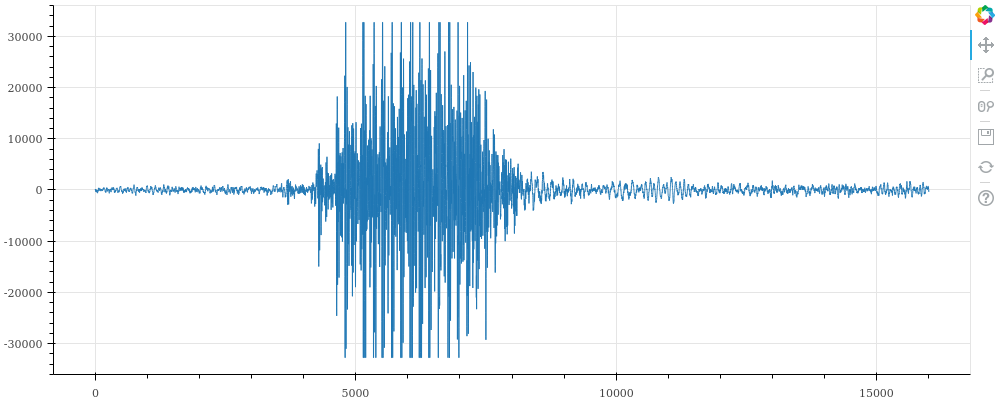

In [14]:
test[119965].hear_and_see()  # 51511, 120099, 1234, 98765, 119965